# Analysis of the DSAIR model

> A number of replications and extensions of the models provided in Han et al. ([2020](https://doi.org/10.1613/jair.1.12225) , [2021](https://doi.org/10.1371/journal.pone.0244592), [2022](https://doi.org/10.1016/j.techsoc.2021.101843) )

In [1]:
#| default_exp analysis_dsair

In [2]:
#| hide
#| export
from gh_pages_example.conditions import *
from gh_pages_example.data_utils import *
from gh_pages_example.methods import *
from gh_pages_example.model_utils import *
from gh_pages_example.payoffs import *
from gh_pages_example.plot_utils import *
from gh_pages_example.types import *
from gh_pages_example.utils import *

import typing
import warnings

import fastcore.test
import matplotlib as mpl
import matplotlib.pyplot as plt
from nbdev.showdoc import *
import nptyping
import numpy as np
import pandas
import seaborn as sns

/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/model_utils.py:299: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (ind not in allowed_inds) and (str(ind) not in allowed_inds):
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/model_utils.py:299: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (ind not in allowed_inds) and (str(ind) not in allowed_inds):
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/methods.py:235: ComplexWarning: Casting complex values to real discards the imaginary part
  ergodic = np.array(V.transpose(0, 2, 1)[y], dtype=float)


This notebook contains a number of analyses of different versions of the DSAIR model.

Each analysis involves a number of steps:

1. Create parameter space
2. Run the model
3. Process the results
4. Visualise results and explain what we observe

## Baseline DSAIR model

### Create parameter space

In [3]:
#| export
valid_dtypes = typing.Union[float, list[float], np.ndarray, dict]
def build_DSAIR(b:valid_dtypes=4, # benefit: The size of the per round benefit of leading the AI development race, b>0
                c:valid_dtypes=1, # cost: The cost of implementing safety recommendations per round, c>0
                s:valid_dtypes={"start":1, # speed: The speed advantage from choosing to ignore safety recommendations, s>1
                                "stop":5.1,
                                "step":0.1}, 
                p:valid_dtypes={"start":0, # avoid_risk: The probability that unsafe firms avoid an AI disaster, p ∈ [0, 1]
                                "stop":1.02,
                                "step":0.02}, 
                B:valid_dtypes=10**4, # prize: The size of the prize from winning the AI development race, B>>b
                W:valid_dtypes=100, # timeline: The anticipated timeline until the development race has a winner if everyone behaves safely, W ∈ [10, 10**6]
                pfo:valid_dtypes=0, # detection risk: The probability that firms who ignore safety precautions are found out, pfo ∈ [0, 1]
                α:valid_dtypes=0, # the cost of rewarding/punishing a peer
                γ:valid_dtypes=0, # the effect of a reward/punishment on a developer's speed
                epsilon:valid_dtypes=0, # commitment_cost: The cost of setting up and maintaining a voluntary commitment, ϵ > 0
                ω:valid_dtypes=0, # noise: Noise in arranging an agreement, with some probability they fail to succeed in making an agreement, ω ∈ [0, 1]
                collective_risk:valid_dtypes=0, # The likelihood that a disaster affects all actors
                β:valid_dtypes=0.01, # learning_rate: the rate at which players imitate each other
                Z:int=100, # population_size: the number of players in the evolutionary game
                strategy_set:list[str]=["AS", "AU"], # the set of available strategies
                exclude_args:list[str]=['Z', 'strategy_set'], # a list of arguments that should be returned as they are
                override:bool=False, # whether to build the grid if it is very large
                drop_args:list[str]=['override', 'exclude_args', 'drop_args'], # a list of arguments to drop from the final result
               ) -> dict: # A dictionary containing items from `ModelTypeDSAIR` and `ModelTypeEGT`
    """Initialise baseline DSAIR models for all combinations of the provided
    parameter valules. By default, we create models for replicating Figure 1
    of Han et al. 2021."""
    
    saved_args = locals()
    models = model_builder(saved_args,
                           exclude_args=exclude_args,
                           override=override,
                           drop_args=drop_args)
    return models

In [4]:
show_doc(build_DSAIR)

---

[source](https://github.com/PaoloBova/gh-pages-example/blob/main/gh_pages_example/payoffs.py#L19){target="_blank" style="float:right; font-size:smaller"}

### build_DSAIR

>      build_DSAIR (b:Union[float,list[float],numpy.ndarray,dict]=4,
>                   c:Union[float,list[float],numpy.ndarray,dict]=1,
>                   s:Union[float,list[float],numpy.ndarray,dict]={'start': 1,
>                   'stop': 5.1, 'step': 0.1},
>                   p:Union[float,list[float],numpy.ndarray,dict]={'start': 0,
>                   'stop': 1.02, 'step': 0.02},
>                   B:Union[float,list[float],numpy.ndarray,dict]=10000,
>                   W:Union[float,list[float],numpy.ndarray,dict]=100,
>                   pfo:Union[float,list[float],numpy.ndarray,dict]=0,
>                   α:Union[float,list[float],numpy.ndarray,dict]=0,
>                   γ:Union[float,list[float],numpy.ndarray,dict]=0,
>                   epsilon:Union[float,list[float],numpy.ndarray,dict]=0,
>                   ω:Union[float,list[float],numpy.ndarray,dict]=0, collective_
>                   risk:Union[float,list[float],numpy.ndarray,dict]=0,
>                   β:Union[float,list[float],numpy.ndarray,dict]=0.01,
>                   Z:int=100, strategy_set:list[str]=['AS', 'AU'],
>                   exclude_args:list[str]=['Z', 'strategy_set'],
>                   override:bool=False, drop_args:list[str]=['override',
>                   'exclude_args', 'drop_args'])

Initialise baseline DSAIR models for all combinations of the provided
parameter valules. By default, we create models for replicating Figure 1
of Han et al. 2021.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| b | Union | 4 | benefit: The size of the per round benefit of leading the AI development race, b>0 |
| c | Union | 1 | cost: The cost of implementing safety recommendations per round, c>0 |
| s | Union | {'start': 1, 'stop': 5.1, 'step': 0.1} | speed: The speed advantage from choosing to ignore safety recommendations, s>1 |
| p | Union | {'start': 0, 'stop': 1.02, 'step': 0.02} | avoid_risk: The probability that unsafe firms avoid an AI disaster, p ∈ [0, 1] |
| B | Union | 10000 | prize: The size of the prize from winning the AI development race, B>>b |
| W | Union | 100 | timeline: The anticipated timeline until the development race has a winner if everyone behaves safely, W ∈ [10, 10**6] |
| pfo | Union | 0 | detection risk: The probability that firms who ignore safety precautions are found out, pfo ∈ [0, 1] |
| α | Union | 0 | the cost of rewarding/punishing a peer |
| γ | Union | 0 | the effect of a reward/punishment on a developer's speed |
| epsilon | Union | 0 | commitment_cost: The cost of setting up and maintaining a voluntary commitment, ϵ > 0 |
| ω | Union | 0 | noise: Noise in arranging an agreement, with some probability they fail to succeed in making an agreement, ω ∈ [0, 1] |
| collective_risk | Union | 0 | The likelihood that a disaster affects all actors |
| β | Union | 0.01 | learning_rate: the rate at which players imitate each other |
| Z | int | 100 | population_size: the number of players in the evolutionary game |
| strategy_set | list | ['AS', 'AU'] | the set of available strategies |
| exclude_args | list | ['Z', 'strategy_set'] | a list of arguments that should be returned as they are |
| override | bool | False | whether to build the grid if it is very large |
| drop_args | list | ['override', 'exclude_args', 'drop_args'] | a list of arguments to drop from the final result |
| **Returns** | **dict** |  | **A dictionary containing items from `ModelTypeDSAIR` and `ModelTypeEGT`** |

In [34]:
#| exec_doc
#| echo:true
models = build_DSAIR()

In [24]:
#| hide
models

{'s': array([1., 1., 1., ..., 5., 5., 5.]),
 'p': array([0.  , 0.02, 0.04, ..., 0.96, 0.98, 1.  ]),
 'b': array([4, 4, 4, ..., 4, 4, 4]),
 'c': array([1, 1, 1, ..., 1, 1, 1]),
 'B': array([10000, 10000, 10000, ..., 10000, 10000, 10000]),
 'W': array([100, 100, 100, ..., 100, 100, 100]),
 'pfo': array([0, 0, 0, ..., 0, 0, 0]),
 'α': array([0, 0, 0, ..., 0, 0, 0]),
 'γ': array([0, 0, 0, ..., 0, 0, 0]),
 'epsilon': array([0, 0, 0, ..., 0, 0, 0]),
 'ω': array([0, 0, 0, ..., 0, 0, 0]),
 'collective_risk': array([0, 0, 0, ..., 0, 0, 0]),
 'β': array([100, 100, 100, ..., 100, 100, 100]),
 'Z': 100,
 'strategy_set': ['AS', 'AU']}

In [25]:
#| hide
{k:v.shape for k,v in models.items() if isinstance(v, np.ndarray)}

{'s': (2091,),
 'p': (2091,),
 'b': (2091,),
 'c': (2091,),
 'B': (2091,),
 'W': (2091,),
 'pfo': (2091,),
 'α': (2091,),
 'γ': (2091,),
 'epsilon': (2091,),
 'ω': (2091,),
 'collective_risk': (2091,),
 'β': (2091,)}

### Run the model

I use `thread_macro` to pipe the `models` I created earlier through each function that follows.

I first build the payoff matrices for each model, and compute some analytical thresholds that will be useful in our discussion. Finally, I pass the result to `markov_chain`, a method for computing the distribution of strategies that will be present in the population in the long run.

In [26]:
#| exec_doc
#| echo:true
results = thread_macro(models,
                       payoffs_sr,
                       payoffs_lr,
                       threshold_society_prefers_safety_dsair,
                       threshold_risk_dominant_safety_dsair,
                       markov_chain,
                      )

/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:39: RuntimeWarning: invalid value encountered in divide
  (-b + (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:42: RuntimeWarning: divide by zero encountered in divide
  (-b - (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:68: RuntimeWarning: invalid value encountered in divide
  (-b + (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:71: RuntimeWarning: divide by zero encountered in divide
  (-b - (b**2 - 4*a*c)**0.5)/(2*a))


In [27]:
#| hide
{k:v.shape for k,v in results.items() if isinstance(v, np.ndarray)}

{'s': (2091,),
 'p': (2091,),
 'b': (2091,),
 'c': (2091,),
 'B': (2091,),
 'W': (2091,),
 'pfo': (2091,),
 'α': (2091,),
 'γ': (2091,),
 'epsilon': (2091,),
 'ω': (2091,),
 'collective_risk': (2091,),
 'β': (2091,),
 'payoffs_sr': (2091, 2, 2),
 'payoffs': (2091, 2, 2),
 'threshold_society_prefers_safety': (2091,),
 'threshold_society_prefers_safety_alt': (2091,),
 'threshold_risk_dominant_safety': (2091,),
 'threshold_risk_dominant_safety_alt': (2091,),
 'transition_matrix': (2091, 2, 2),
 'ergodic': (2091, 2)}

### Process the results

Now that we have collected some results, we need to process them so that we can display what we want to.

The general approach I follow is to flatten the `results` dictionary and convert it into a [pandas](https://pandas.pydata.org/pandas-docs/stable/index.html) dataframe. I have a convenience function called `results_to_dataframe_egt` for this purpose.

In `process_dsair_data`, we also compute the risk of an AI related disaster, $p_{risk} = 1 - p$

In [28]:
#| exec_doc
df = thread_macro(results,
                  results_to_dataframe_egt,
                  process_dsair_data)

In [29]:
#| echo:false
df

,s,p,b,c,B,W,pfo,α,γ,epsilon,ω,collective_risk,β,threshold_society_prefers_safety,threshold_society_prefers_safety_alt,threshold_risk_dominant_safety,threshold_risk_dominant_safety_alt,AS_frequency,AU_frequency,pr
0,1.0,0.00,4,1,10000,100,0,0,0,0,0,0,100,0.019231,0.019231,0.662338,0.662338,1.000000e+00,7.196542e-220,1.00
1,1.0,0.02,4,1,10000,100,0,0,0,0,0,0,100,0.019231,0.019231,0.662338,0.662338,1.000000e+00,0.000000e+00,0.98
2,1.0,0.04,4,1,10000,100,0,0,0,0,0,0,100,0.019231,0.019231,0.662338,0.662338,1.000000e+00,0.000000e+00,0.96
3,1.0,0.06,4,1,10000,100,0,0,0,0,0,0,100,0.019231,0.019231,0.662338,0.662338,1.000000e+00,0.000000e+00,0.94
4,1.0,0.08,4,1,10000,100,0,0,0,0,0,0,100,0.019231,0.019231,0.662338,0.662338,1.000000e+00,0.000000e+00,0.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2086,5.0,0.92,4,1,10000,100,0,0,0,0,0,0,100,0.797619,0.797619,0.932921,0.932921,7.196542e-220,1.000000e+00,0.08
2087,5.0,0.94,4,1,10000,100,0,0,0,0,0,0,100,0.797619,0.797619,0.932921,0.932921,7.196542e-220,1.000000e+00,0.06
2088,5.0,0.96,4,1,10000,100,0,0,0,0,0,0,100,0.797619,0.797619,0.932921,0.932921,7.196542e-220,1.000000e+00,0.04
2089,5.0,0.98,4,1,10000,100,0,0,0,0,0,0,100,0.797619,0.797619,0.932921,0.932921,7.196542e-220,1.000000e+00,0.02


### Visualise results and explain what we observe

I am using the [Matplotlib](https://matplotlib.org/stable/index.html) library to visualize our data.

#| hide

:::{.callout-note}
Note that there are five types of callouts, including: 
`note`, `tip`, `warning`, `caution`, and `important`.
:::

In [30]:
#| hide
sns.set_theme(style='darkgrid',palette='deep' ,font='sans-serif', font_scale=1.4)
plt.rcParams["axes.grid"] = False

I first replicate Figure 1 from The Anh Han et al. 2021

The figure describes how the the frequency of Always Unsafe (**AU**) varies with both the speed advantage given to those who play **AU**, $s$, and the risk that such firms cause an AI disaster, $p_{risk}$. We have also plotted two lines, the lower line shows the boundary where society is indifferent between the two strategies. A greater risk or a slower speed advantage from this boundary implies society prefers players to play Always Safe (**AS**). The higher line shows the threshold for which **AU** is risk dominant over **AS**. For this baseline model, risk dominance implies that the strategy will be selected for by evolution (which is why the line follows the boundary where players switch from **AU** to **AS**). As with the lower line, any higher risk or lower speed implies that **AS** will instead by risk dominant over **AU**.

These lines therefore split the heatmap into 3 regions. 
(i) Society prefers **AS** and **AS** is selected by social learning.
(ii) Society prefers **AS** but **AU** is selected by social learning
(iii) Society prefers **AU** and **AU** is selected by social learning

In region (i) companies will be alligned with Society's preference for safety. In region (iii), society is willing to accept the risks as they anticipate greater benefits from innovation. In region (ii), we see a dilemma where all players are choosing to play **AU**, even though society prefers them to play **AS**. We can refer to this region as the *Dilemma zone*.

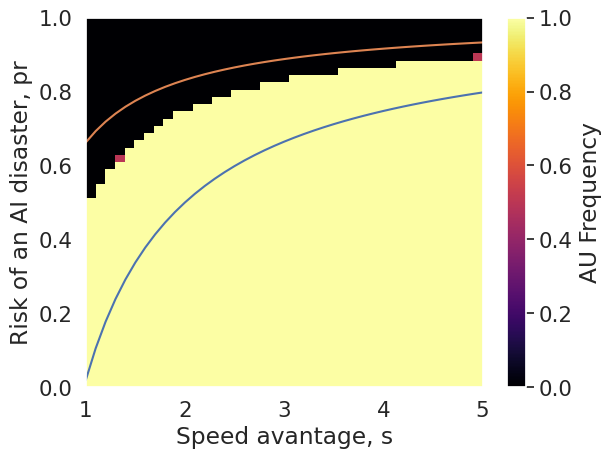

In [31]:
#| echo:false
table = df.pivot_table(index='pr', columns='s', values='AU_frequency')
plot_heatmap(table,
             xlabel='Speed avantage, s',
             ylabel='Risk of an AI disaster, pr',
             zlabel='AU Frequency',
             cmap='inferno',
            )

# Add threshold boundaries to convey dilemma region
plt.plot(table.columns, df[df.pr==1]['threshold_society_prefers_safety'])
plt.plot(table.columns, df[df.pr==1]['threshold_risk_dominant_safety']);

:::{.callout-caution}
Note that this model is illustrative only: at best here, society refers to the collection of all firms.

We could instead explicitly model society's preferences over safety and innovation, distinct from the companies. Such a model will still have the 3 regions we are currently discussing, though the negative externalities of an AI disaster will likely lead to a greater *dillemma zone*. 

Another insight that such an extension would communicate is that companies may have incentive to work together to make sure their preferences are weighted more highly than the rest of society. It would be interesting to see whether we can observe this in pracitse, for examle in the European AI Act. The main challenge this task presents us is how to determine whether companies are working together to have their voices heard or whether they each already have strong enough incentives to uniltaterally influence policy.
:::

I have also plotted a cross-section of the above heatmap for speed advantage, $s=1.5$. This plot shows how players are distributed between the 2 available strategies, $AU$ and $AS$. Here, the blue area represents the proportion of players who follow $AU$ for each level of risk, whereas the red area tells us the proportion who play $AS$. I also mark the 3 regions discussed above.

We will often make use of this cross-section plot in more complex models when we want to show the relative frequencies of more than 2 strategies. 

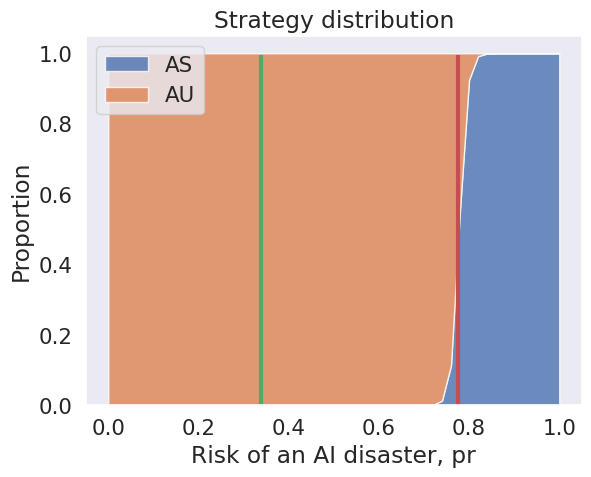

In [ ]:
#| echo:false
plot_strategy_distribution(df[df.s==1.5],
                           results['strategy_set'],
                           x="pr"
                          )

## DSAIR with punishment

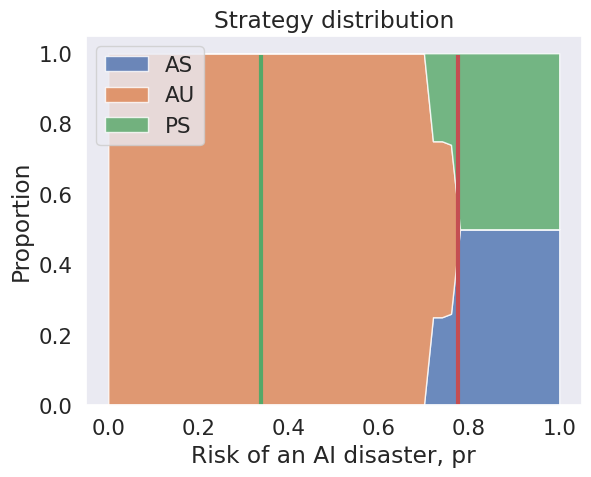

In [ ]:
#| exec_doc
#| echo:false
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    models = build_DSAIR(b=4,
                         c=1,
                         B=10**4,
                         W=100,
                         pfo=0,
                         α=0,
                         γ=0,
                         epsilon=0,
                         ω=0,
                         collective_risk=0,
                         β=0.1,
                         Z=100,
                         strategy_set=["AS", "AU", "PS"],
                        )

    results = thread_macro(models,
                           payoffs_sr,
                           payoffs_lr_peer_punishment,
                           threshold_society_prefers_safety_dsair,
                           threshold_risk_dominant_safety_dsair,
                           markov_chain,
                          )

    df = thread_macro(results,
                      results_to_dataframe_egt,
                      process_dsair_data)

    plot_strategy_distribution(df[df.s==1.5],
                               results['strategy_set'],
                               x="pr"
                              )

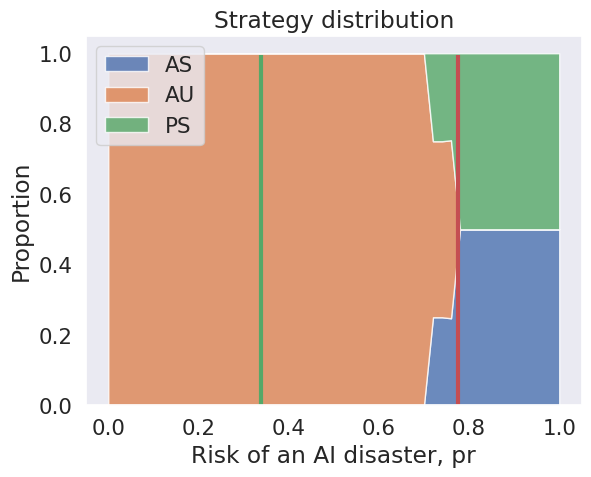

In [ ]:
#| exec_doc
#| echo:false
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    models = build_DSAIR(b=4,
                         c=1,
                         B=10**4,
                         W=100,
                         α=0.5,
                         γ=0.5,
                         β=0.1,
                         Z=100,
                         strategy_set=["AS", "AU", "PS"],
                         collective_risk=0)

    results = thread_macro(models,
                           payoffs_sr,
                           payoffs_lr_peer_punishment,
                           threshold_society_prefers_safety_dsair,
                           threshold_risk_dominant_safety_dsair,
                           markov_chain,
                          )

    df = thread_macro(results,
                      results_to_dataframe_egt,
                      process_dsair_data)

    plot_strategy_distribution(df[df.s==1.5],
                               results['strategy_set'],
                               x="pr"
                              )

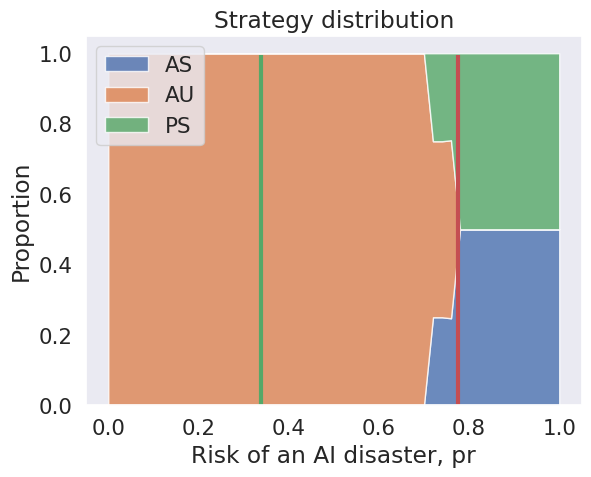

In [ ]:
#| exec_doc
#| echo:false
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    models = build_DSAIR(b=4,
                         c=1,
                         B=10**4,
                         W=100,
                         α=0.4,
                         γ=0.5,
                         β=0.1,
                         Z=100,
                         strategy_set=["AS", "AU", "PS"],
                         collective_risk=0)

    results = thread_macro(models,
                           payoffs_sr,
                           payoffs_lr_peer_punishment,
                           threshold_society_prefers_safety_dsair,
                           threshold_risk_dominant_safety_dsair,
                           markov_chain,
                          )

    df = thread_macro(results,
                      results_to_dataframe_egt,
                      process_dsair_data)

    plot_strategy_distribution(df[df.s==1.5],
                               results['strategy_set'],
                               x="pr"
                              )

The above plots show what the addition of peer punishment can do for the dynamics of an AI Development race. In the scenario presented above, a sufficiently large punishment can completely eliminate unsafe behaviour, even when the cost is somewhat large for the sanctioner (plot 3).

We compare this to a scenario where the sanctioner is all talk (i.e. punishment is costless to both parties). Here, we see no difference in the distribution of strategies compared to the baseline model (plot 1)

When the punishment hurts both parties equally, we see that it can curtail unsafe behavior, but to a far lesser extent. In such a scenario, it is more difficult for **PS** players to survive, so they provide less protection to **AS** players from **AS** players (plot 2).

One important takeaway which is apparent above is that punishments can be too punishing. Even when society collectively prefers that players are **AU**, punishment can prevent players from doing so. 

This isn't an obvious problem to overcome. Due to the Colignridge Dilemma, it will be very difficult for companies to determine what the risk of an AI disaster will be. 

We have so far only looked at short timelines. On longer timelines, we would expect punishments to be less effective, but we also expect the dilemma region to be smaller, so an interesting question is whether we should expect punishments to be as overzealous in restricting behaviour. Could it even be that punishments are insufficient to remove the dilemma zone on longer timelines?

The answer is yes to both questions. See the plots below.

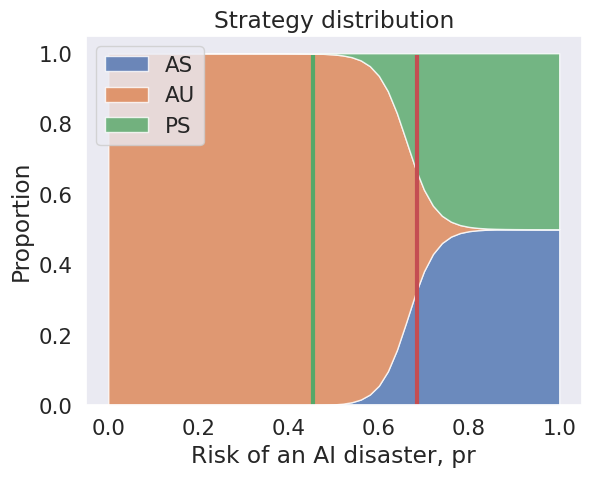

In [ ]:
#| exec_doc
#| echo:false
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    models = build_DSAIR(b=4,
                         c=1,
                         B=10**4,
                         W=10**4,
                         α=0.4,
                         γ=0.5,
                         β=0.1,
                         Z=100,
                         strategy_set=["AS", "AU", "PS"],
                         collective_risk=0)

    results = thread_macro(models,
                           payoffs_sr,
                           payoffs_lr_peer_punishment,
                           threshold_society_prefers_safety_dsair,
                           threshold_risk_dominant_safety_dsair,
                           markov_chain,
                          )

    df = thread_macro(results,
                      results_to_dataframe_egt,
                      process_dsair_data)

    plot_strategy_distribution(df[df.s==1.5],
                               results['strategy_set'],
                               x="pr"
                              )

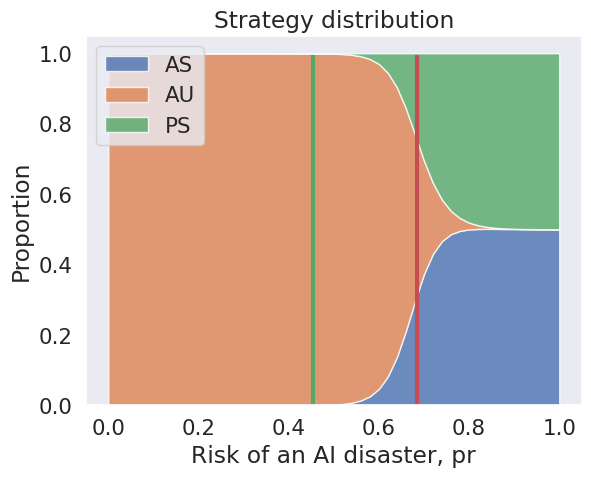

In [ ]:
#| exec_doc
#| echo:false
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    models = build_DSAIR(b=4,
                         c=1,
                         B=10**4,
                         W=10**4,
                         α=0.5,
                         γ=0.5,
                         β=0.1,
                         Z=100,
                         strategy_set=["AS", "AU", "PS"],
                         collective_risk=0)

    results = thread_macro(models,
                           payoffs_sr,
                           payoffs_lr_peer_punishment,
                           threshold_society_prefers_safety_dsair,
                           threshold_risk_dominant_safety_dsair,
                           markov_chain,
                          )

    df = thread_macro(results,
                      results_to_dataframe_egt,
                      process_dsair_data)

    plot_strategy_distribution(df[df.s==1.5],
                               results['strategy_set'],
                               x="pr"
                              )
    plt.savefig('placeholder.png')

Below, I replicate 3 of the subfigures from Figure 5 of Han et al 2021, Mediating AI development races with incentives. 

All these figures show th effects of punishment in a typical AI development race on a short timescale.

These figures show the effects of punishment as it varies in efficiency for a range of AI risk levels. With larger risk, players are more likely to play safe anyways, so punishments are rarely used. When risk is much lower, players prefer to be unsafe, although efficient punishments deter risk taking behaviour. Efficient punishments can mitigate unsafe behaviour when AI risk is in an intermediate stage, where it is not high enough to motivate firms to be safe, but is still high enough in principle to warrant their caution on society's behalf.

Note again that these numbers are illustrative. Depending on the size of a disaster, much lower levels of risk may demand caution from the international community.

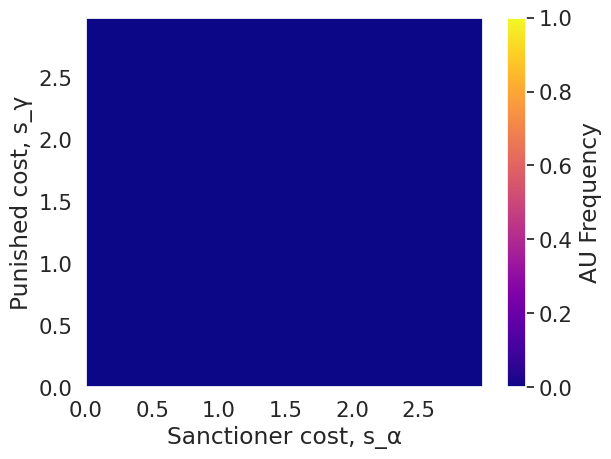

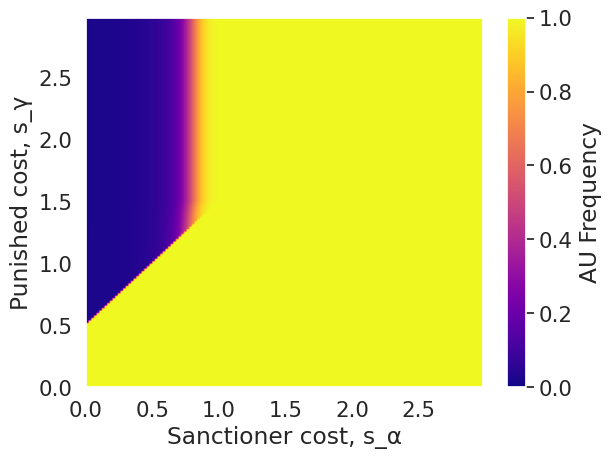

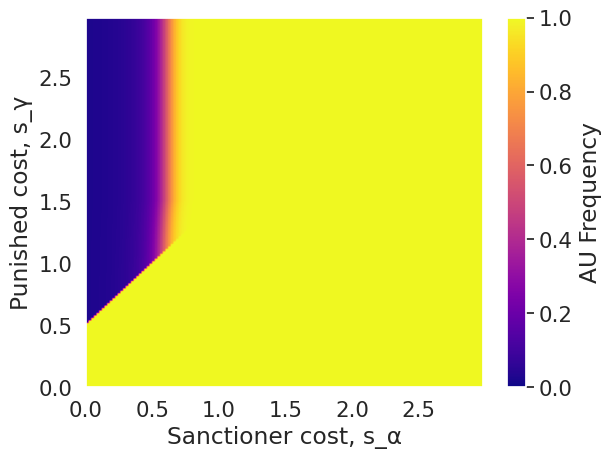

In [ ]:
#| exec_doc
#| echo:false
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    models = build_DSAIR(b=4,
                         c=1,
                         p=[0.1, 0.5, 0.75],
                         s=1.5,
                         B=10**4,
                         W=10**2,
                         pfo=0,
                         α=np.arange(0, 3, 0.02),
                         γ=np.arange(0, 3, 0.02),
                         β=0.01,
                         Z=100,
                         strategy_set=["AS", "AU", "PS"],
                         collective_risk=0)

    results = thread_macro(models,
                           payoffs_sr_pfo_extension,
                           payoffs_lr_peer_punishment,
                           threshold_society_prefers_safety_dsair,
                           threshold_risk_dominant_safety_dsair,
                           markov_chain,
                          )

    df = thread_macro(results,
                      results_to_dataframe_egt,
                      process_dsair_data)
    
    for p in [0.1, 0.5, 0.75]:
        table = df[df.p==p].pivot_table(index='γ', columns='α', values='AU_frequency')
        plot_heatmap(table,
                     xlabel='Sanctioner cost, s_α',
                     ylabel='Punished cost, s_γ',
                     zlabel='AU Frequency',
                     cmap='plasma',
                    )

Below, I replicate another figure from the paper. We display the frequency of **Always Unsafe** for a range of speed advantages and risk levels. The presence of a Peer Punishment strategy appears to mitigate the dilemma zone we noted earlier. Here, punishments are 75% effective in slowing down unsafe firms and apply the same slowdown to the sanctioner who levied the punishment, $s_γ=s_α=3s/4$.

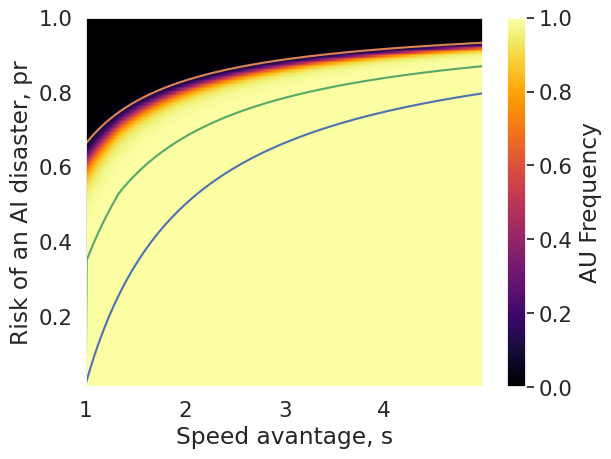

In [ ]:
#| exec_doc
#| echo:false
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    models = build_DSAIR(b=4,
                         c=1,
                         p=np.arange(0, 1, 0.01),
                         s=np.arange(1, 5, 0.01),
                         B=10**4,
                         W=10**2,
                         pfo=0,
                         α=0,
                         γ=0,
                         β=0.01,
                         Z=100,
                         strategy_set=["AS", "AU", "PS"],
                         collective_risk=0)
    # This time, we set α and γ as functions of s
    models['α'] = 3/4 * models['s']
    models['γ'] = 3/4 * models['s']
    results = thread_macro(models,
                           payoffs_sr_pfo_extension,
                           payoffs_lr_peer_punishment,
                           threshold_society_prefers_safety_dsair,
                           threshold_risk_dominant_safety_dsair,
                           threshold_ps_r_d_au,
                           markov_chain,
                          )

    df = thread_macro(results,
                      results_to_dataframe_egt,
                      process_dsair_data)
    table = df.pivot_table(index='pr', columns='s', values='AU_frequency')
    plot_heatmap(table,
             xlabel='Speed avantage, s',
             ylabel='Risk of an AI disaster, pr',
             zlabel='AU Frequency',
             cmap='inferno',
            )
    
    # Add threshold boundaries to convey dilemma region
    plt.plot(table.columns, df[df.pr==1]['threshold_society_prefers_safety'])
    plt.plot(table.columns, df[df.pr==1]['threshold_risk_dominant_safety'])
    plt.plot(table.columns, df[df.pr==0.5]['threshold_ps_risk_dominates_au']);

The above figure looks fairly similar to the paper. However, I intuitively expected the reduction in AU to be more significant. Try making this graph specifically in mathematica and see what comes up.

### Punishments on longer timelines

I now extend the analysis of punishments to longer timelines. A longer timeline implies that any large benefits from winning the development race are likely to occur farther into the future, which means that they may be weighted less than before relative to the benefits of selling AI services in the current period (we capture this by looking at the average payoffs to firms over the duration of the race).

It is likely that increasing timelines has the same effect as reducing the prize from winning the race. This is in fact the case for the DSAIR model without punishments. Either change in the simpler model would ubiquitously reduce incentives to race unsafely.

In the case of punishments, the story is somewhat more complicated. On the one hand, it is now easier for punishments of different levels of impact to not only disincentivise but also stop the R&D activities of unsafe firms. On the other hand, it also means that firms who levy the punishments could more easily fail to survive the experience. If such firms are less able to survive, they are less likely to offer protection to safe firms from being exploited by unsafe firms. 

Nevertheless, we should longer timescales to lead to a net increase in punishment efficiency, as safer firms who levy punishments are less motivated by the long-run prize in the first place.

Yet, a more nuanced question is whether this is what society wants? On longer timelines, society is likely to want to encourage more risk taking. We should anticipate that the improved efficacy of punishments should in some scenarios conflict with society's preferences. This would be particularly troubling if this were to lead to backlash against the punishers, especially if society's preferences failed to capture important negative externalities that could arise from risky technology races (e.g. the tail risk of a catastrophe caused by the misuse of autonomous weapons).

How can we represent a longer timeline?

We represent short timelines as taking $W=100$ time periods. If we assume firms can act nearly every month, then this corresponds to a timeline of around 10 years.

Surveys of AI experts suggest that those with longer timelines assume the development of AI systems which surprass humans in all domains to at least take a century, so a $W=1000$ seems appropriate (see Katja et al. 2016, Carlier et al, Brundage et al.). However, note that there are timelines where the development of transformative AI systems place longer timelines at around 60 years instead, see Cotra 2020 (transformative AI systems are sufficient to cause radical economic change to a similar degree than the industrial revolution).

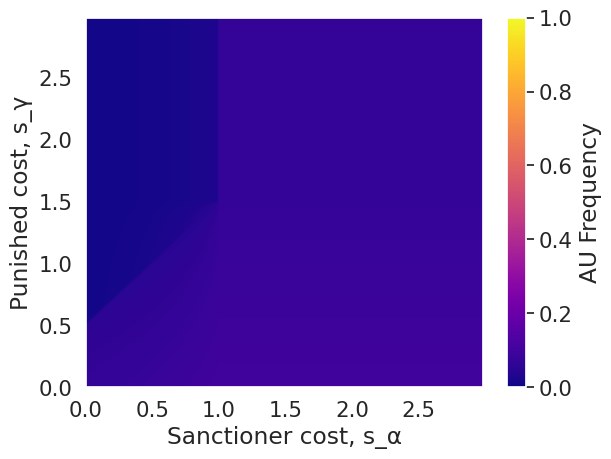

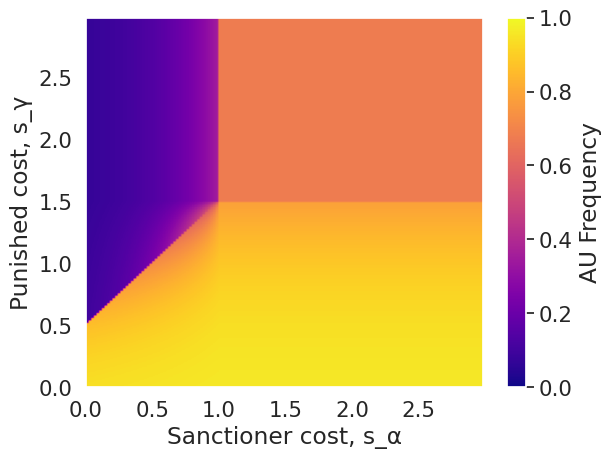

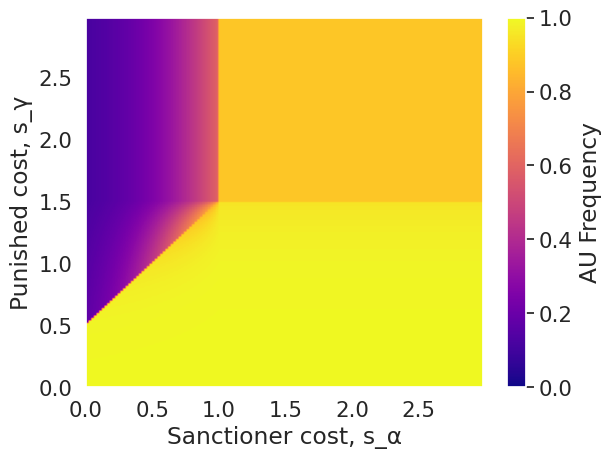

In [ ]:
#| exec_doc
#| echo:false
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    models = build_DSAIR(b=4,
                         c=1,
                         p=[0.1, 0.5, 0.75],
                         s=1.5,
                         B=10**4,
                         W=10**3,
                         pfo=0,
                         α=np.arange(0, 3, 0.02),
                         γ=np.arange(0, 3, 0.02),
                         β=0.01,
                         Z=100,
                         strategy_set=["AS", "AU", "PS"],
                         collective_risk=0)

    results = thread_macro(models,
                           payoffs_sr_pfo_extension,
                           payoffs_lr_peer_punishment,
                           threshold_society_prefers_safety_dsair,
                           threshold_risk_dominant_safety_dsair,
                           markov_chain,
                          )

    df = thread_macro(results,
                      results_to_dataframe_egt,
                      process_dsair_data)
    
    for p in [0.1, 0.5, 0.75]:
        table = df[df.p==p].pivot_table(index='γ', columns='α', values='AU_frequency')
        plot_heatmap(table,
                     xlabel='Sanctioner cost, s_α',
                     ylabel='Punished cost, s_γ',
                     zlabel='AU Frequency',
                     cmap='plasma',
                    )

Are the results above for a longer timeline what we anticipated?

Taking each graph in order, starting with the figure for high AI risk, we see that unsafe behaviour is barely present (though it is perhaps notable that on a longer timeline, the slightly different shades indicate that firms are unsafe for a very small percentage of time, which vanishes with more efficient punishments).

For the figure with intermediate risk, the differences with shorter timelines are more apparent. Unsafe frequencies are much smaller and there is a larger region where no unsafe behaviour is present at all. 

The final figure with low risk tells a similar story. The region where no unsafe behaviour is present is very large and the region where all companies are unsafe is smaller than on a shorter timeline.

How do we find the interaction effect of longer timelines with punishments. To isolate this interaction effect, we could take the difference of the two plots. If longer timelines had a uniform effect on unsafe behaviour, then the differences would be constant. Our results above already indicate that there is no such uniform effect. 

However, it may be of interest to know whether the effect of longer timelines is weaker for more efficient punishmens and stronger for less efficient ones. This effect is more difficult to determine, as the most efficient punishments already quell all unsafe behaviour. Though, on close inspection of the figures above, one can see that clearly the difference is greatest where punishments would otherwise have just failed to reduce unsafe behaviour, near the boundary where on shorter timelines for the last two plots we see a quick switch from punishments completely stopping unsafe behavior to failing to stop any unsafe behaviour at all. This is strong evidence that longer timelines intensify the effect of punishments on unsafe behaviour.

To answer whether this is what society wants (ignoring externalities), I now plot the unsafe frequencies for a range of AI risk levels and speed advantages, as well as the thresholds for when society prefers safety and when unsafe behaviour would usually dominate safe behaviour in the absense of punishment strategies. If you recall our earlier discussion, these thresholds split the figure into 3 regions, the middle region representing a *dilemma zone* where safety is collectively preffered but unsafe behaviour is what everyone learns to do.

Before we consider this figure, you may wish to remind yourself of the analogous figure for shorter timelines. We saw that punishments which were equivalent to a reduction of 75% the speed that unsafe firms could obtain were only somewhat effective in shrinking the dilemma zone. This was consistent with our earlier figures since equal and relatively large speed reductions for the sanctioner and punished would place us closer to the upper right corner of those figures which plotted the unsafe frequencies as we varied the sanctioner and punished costs.

However, we know that longer timelines allow punishments to be considerably more effective, even in those areas. We should anticipate a greater shrinkage of the dilemma zone. Whether this is what society wants is less clear from the outset. It is plausible that unsafe behaviour diminishes so much that it eats into the region where risk taking is prefferred by society over safety.

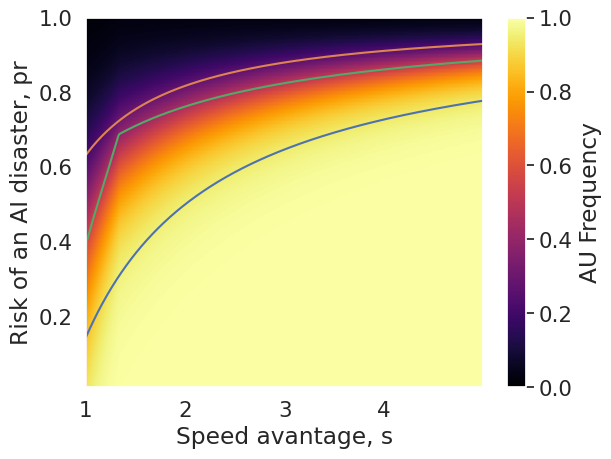

In [ ]:
#| exec_doc
#| echo:false
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    models = build_DSAIR(b=4,
                         c=1,
                         p=np.arange(0, 1, 0.01),
                         s=np.arange(1, 5, 0.01),
                         B=10**4,
                         W=10**3,
                         pfo=0,
                         α=0,
                         γ=0,
                         β=0.01,
                         Z=100,
                         strategy_set=["AS", "AU", "PS"],
                         collective_risk=0)
    # This time, we set α and γ as functions of s
    models['α'] = 3/4 * models['s']
    models['γ'] = 3/4 * models['s']
    results = thread_macro(models,
                           payoffs_sr_pfo_extension,
                           payoffs_lr_peer_punishment,
                           threshold_society_prefers_safety_dsair,
                           threshold_risk_dominant_safety_dsair,
                           threshold_ps_r_d_au,
                           markov_chain,
                          )

    df = thread_macro(results,
                      results_to_dataframe_egt,
                      process_dsair_data)
    table = df.pivot_table(index='pr', columns='s', values='AU_frequency')
    plot_heatmap(table,
             xlabel='Speed avantage, s',
             ylabel='Risk of an AI disaster, pr',
             zlabel='AU Frequency',
             cmap='inferno',
            )
    
    # Add threshold boundaries to convey dilemma region
    plt.plot(table.columns, df[df.pr==1]['threshold_society_prefers_safety'])
    plt.plot(table.columns, df[df.pr==1]['threshold_risk_dominant_safety'])
    plt.plot(table.columns, df[df.pr==0.5]['threshold_ps_risk_dominates_au']);

The figure above is surprising. First, notice that the threshold AI risk level for society to prefer safety is higher than before as expected (the threshold for unsafe behaviour risk dominating safe behaviour should appear to be somewhat lower, but the difference in this case is barely apparent).

Most dramatic is the reduciton in unsafe behaviour in the dilemma zone. Although the frequency is still above 50% for most of the dilemma zone, the overall effect is much higher than on shorter timelines. Note that we have also plotted the threshold for the Sanctioners to risk dominate the unsafe firms they punish. Even though this threshold is very close to the threshold before safe behaviour is risk dominant, we still see a dramatic reduction in unsafe behaviour before this. Even if sanctioners are not selected for by evolution, they can still catalyse safe behaviour.

My warnings of overegulation in this scenario are unwarranted. While there is a slight reduction in risk taking behaviour in the lower left corner where AI risk and the speed advantage are small, the effect is minimal. 

What is more interesting is the effect when risk is higher. It is notable that even when safe behaviour is risk dominant, that a small percentage of firms still choose to be unsafe. This happens because the average payoffs for safe firms when against other safe firms also falls with the longer timeline. Tied with our relatively weak learning rate, $beta=0.01$, this leads to a less dramatic swtich from unsafe to safe behaviour. Importantly, this is not a consequence of the punishments themselves.

One other check I would like to do is to see if the figure would be similar if we had instead shrunk the prize directly by a factor of $10$. In the simpler DSAIR model, this change would be equivalent a $10$ times longer timeline, since players only considered the average prize over the duration of the timeline.

However, our punishments ensure that players who are unsafe, players who are unsafe but who are punished, players who are safe but sanction unsafe players, and safe players would all finish the race at different times. This implies that the effect of punishments could be starkly different than if we had shrunk the prize directly. Where it not so, if extending the timeline had the same effect as a direct prize reduction, then we might have anticipated that punishments had a qualitatively similar effect on unsafe behaviour as on shorter timelines. This was not the case.

Let's plot the above figures again with smaller prize, $B$, for comparison.

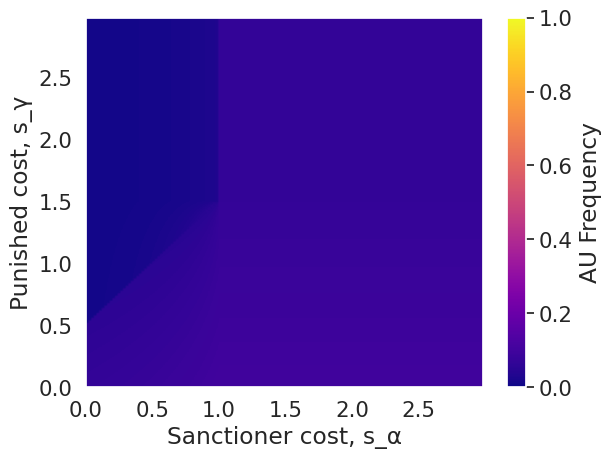

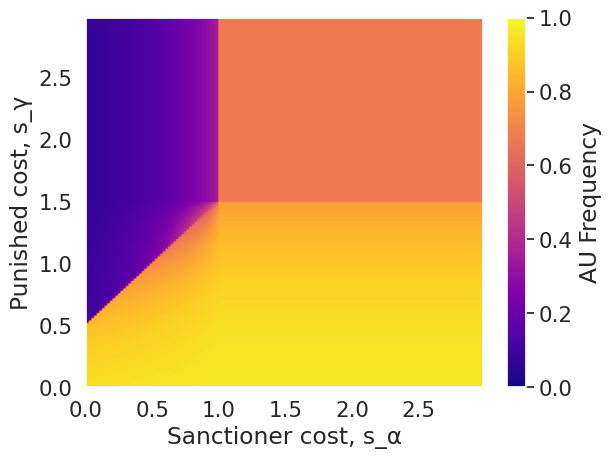

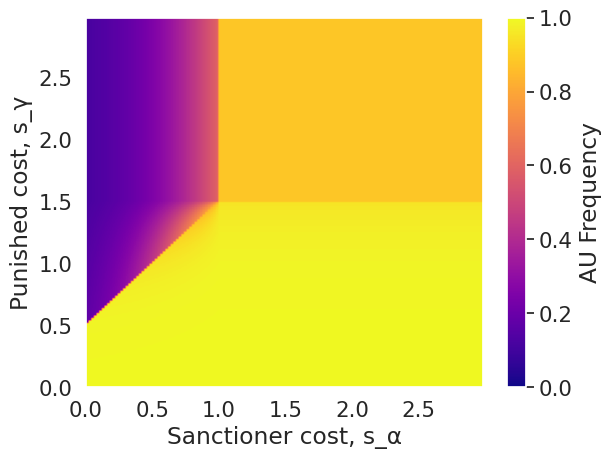

In [ ]:
#| exec_doc
#| echo:false
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    models = build_DSAIR(b=4,
                         c=1,
                         p=[0.1, 0.5, 0.75],
                         s=1.5,
                         B=10**3,
                         W=10**2,
                         pfo=0,
                         α=np.arange(0, 3, 0.02),
                         γ=np.arange(0, 3, 0.02),
                         β=0.01,
                         Z=100,
                         strategy_set=["AS", "AU", "PS"],
                         collective_risk=0)

    results = thread_macro(models,
                           payoffs_sr_pfo_extension,
                           payoffs_lr_peer_punishment,
                           threshold_society_prefers_safety_dsair,
                           threshold_risk_dominant_safety_dsair,
                           markov_chain,
                          )

    df = thread_macro(results,
                      results_to_dataframe_egt,
                      process_dsair_data)
    
    for p in [0.1, 0.5, 0.75]:
        table = df[df.p==p].pivot_table(index='γ', columns='α', values='AU_frequency')
        plot_heatmap(table,
                     xlabel='Sanctioner cost, s_α',
                     ylabel='Punished cost, s_γ',
                     zlabel='AU Frequency',
                     cmap='plasma',
                    )

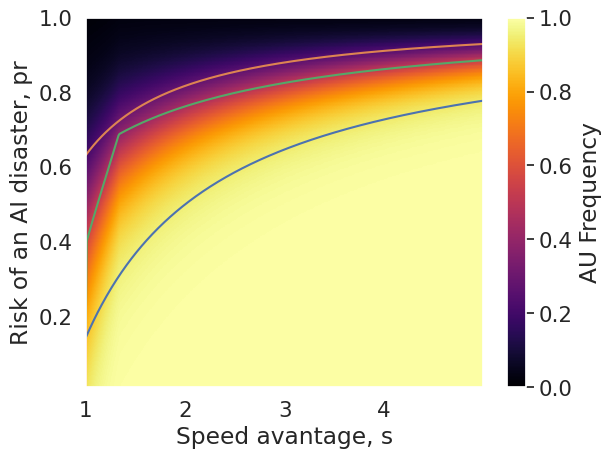

In [ ]:
#| exec_doc
#| echo:false
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    models = build_DSAIR(b=4,
                         c=1,
                         p=np.arange(0, 1, 0.01),
                         s=np.arange(1, 5, 0.01),
                         B=10**3,
                         W=10**2,
                         pfo=0,
                         α=0,
                         γ=0,
                         β=0.01,
                         Z=100,
                         strategy_set=["AS", "AU", "PS"],
                         collective_risk=0)
    # This time, we set α and γ as functions of s
    models['α'] = 3/4 * models['s']
    models['γ'] = 3/4 * models['s']
    results = thread_macro(models,
                           payoffs_sr_pfo_extension,
                           payoffs_lr_peer_punishment,
                           threshold_society_prefers_safety_dsair,
                           threshold_risk_dominant_safety_dsair,
                           threshold_ps_r_d_au,
                           markov_chain,
                          )

    df = thread_macro(results,
                      results_to_dataframe_egt,
                      process_dsair_data)
    table = df.pivot_table(index='pr', columns='s', values='AU_frequency')
    plot_heatmap(table,
             xlabel='Speed avantage, s',
             ylabel='Risk of an AI disaster, pr',
             zlabel='AU Frequency',
             cmap='inferno',
            )
    
    # Add threshold boundaries to convey dilemma region
    plt.plot(table.columns, df[df.pr==1]['threshold_society_prefers_safety'])
    plt.plot(table.columns, df[df.pr==1]['threshold_risk_dominant_safety'])
    plt.plot(table.columns, df[df.pr==0.5]['threshold_ps_risk_dominates_au']);

Again, I am surprised. The smaller prize did in fact have the same effects as a longer timeline. It seems that the asymmetric effects on when sanctioners and the punished finish their races is just not large enough to influence the race independently of the effects of longer timelines. This is likely because it has (i) a negligible effect on who wins the race, and (ii) a negligible effect on the product of the prize and the time taken to win the race.

I should also double check whether the effect is largely driven by timelines rather than the punishments by setting the punishment effects to be $0$.

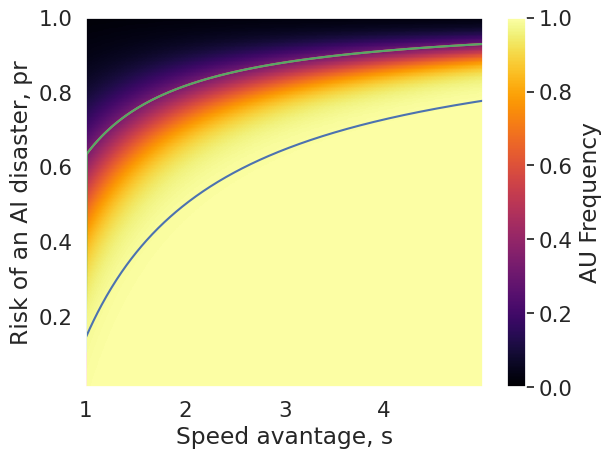

In [ ]:
#| exec_doc
#| echo:false
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    models = build_DSAIR(b=4,
                         c=1,
                         p=np.arange(0, 1, 0.01),
                         s=np.arange(1, 5, 0.01),
                         B=10**3,
                         W=10**2,
                         pfo=0,
                         α=0,
                         γ=0,
                         β=0.01,
                         Z=100,
                         strategy_set=["AS", "AU", "PS"],
                         collective_risk=0)
    # This time, we set α and γ as functions of s
    models['α'] = 0 * models['s']
    models['γ'] = 0 * models['s']
    results = thread_macro(models,
                           payoffs_sr_pfo_extension,
                           payoffs_lr_peer_punishment,
                           threshold_society_prefers_safety_dsair,
                           threshold_risk_dominant_safety_dsair,
                           threshold_ps_r_d_au,
                           markov_chain,
                          )

    df = thread_macro(results,
                      results_to_dataframe_egt,
                      process_dsair_data)
    table = df.pivot_table(index='pr', columns='s', values='AU_frequency')
    plot_heatmap(table,
             xlabel='Speed avantage, s',
             ylabel='Risk of an AI disaster, pr',
             zlabel='AU Frequency',
             cmap='inferno',
            )
    
    # Add threshold boundaries to convey dilemma region
    plt.plot(table.columns, df[df.pr==1]['threshold_society_prefers_safety'])
    plt.plot(table.columns, df[df.pr==1]['threshold_risk_dominant_safety'])
    plt.plot(table.columns, df[df.pr==0.5]['threshold_ps_risk_dominates_au']);

The above figure confirms that most of the effect is from longer timelines independent of its interaction with punishments. However, it is noticeable that longer timelines dramatically boost safety when the speed advantage is low. It also boosts safety for higher speed values, though this may be less aparrent (try spotting the larger purple area at $s=5$).

I should also see whether the above effect on punishments (so punishment costs are no longer $0$) is mainly driven by lower payoffs on average as a whole (by shrinking the learning rate, $\beta$ by a factor of $10$). A glance below suggests that this is the case (there are slight but negligible differences)

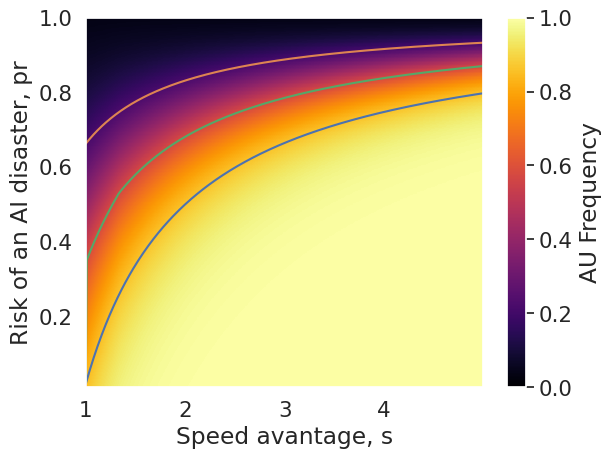

In [ ]:
#| exec_doc
#| echo:false
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    models = build_DSAIR(b=4,
                         c=1,
                         p=np.arange(0, 1, 0.01),
                         s=np.arange(1, 5, 0.01),
                         B=10**4,
                         W=10**2,
                         pfo=0,
                         α=0,
                         γ=0,
                         β=0.001,
                         Z=100,
                         strategy_set=["AS", "AU", "PS"],
                         collective_risk=0)
    # This time, we set α and γ as functions of s
    models['α'] = 3/4 * models['s']
    models['γ'] = 3/4 * models['s']
    results = thread_macro(models,
                           payoffs_sr_pfo_extension,
                           payoffs_lr_peer_punishment,
                           threshold_society_prefers_safety_dsair,
                           threshold_risk_dominant_safety_dsair,
                           threshold_ps_r_d_au,
                           markov_chain,
                          )

    df = thread_macro(results,
                      results_to_dataframe_egt,
                      process_dsair_data)
    table = df.pivot_table(index='pr', columns='s', values='AU_frequency')
    plot_heatmap(table,
             xlabel='Speed avantage, s',
             ylabel='Risk of an AI disaster, pr',
             zlabel='AU Frequency',
             cmap='inferno',
            )
    
    # Add threshold boundaries to convey dilemma region
    plt.plot(table.columns, df[df.pr==1]['threshold_society_prefers_safety'])
    plt.plot(table.columns, df[df.pr==1]['threshold_risk_dominant_safety'])
    plt.plot(table.columns, df[df.pr==0.5]['threshold_ps_risk_dominates_au']);

All in all, it appears that the effects of changing $B$, $W$, and $\beta$ are largely interchangeable, even in the presence of punishments.

One takeaway is that in this simple model, the impact of punishments (as with the rest of the DSAIR models we have considered so far) only considers the average prize over the duration of the timeline. This is a strong assumption which in principle we could devise a test for: do companies really act to increase the average prize they expect over the long run? Do they instead discount future possible gains and act to maximise the net present value of their activities.

Admittedly, the mitigation effects of punishments still appear less than ideal. The *dilemma zones* remains large. 

We could consider a different punishment scheme than we considered in both the short and long timeline scenarios above, one where perhaps due to well-designed incentives, we permit more efficient punishments which are less costly to the sanctioner. In these cases, we are much more likely to reduce unsafe behaviour (perhaps too when risk taking would be collectively desired).

Let's consider naively that this time the speed reduction for sanctioners is only 25% of the speed that unsafe firms can obtain.

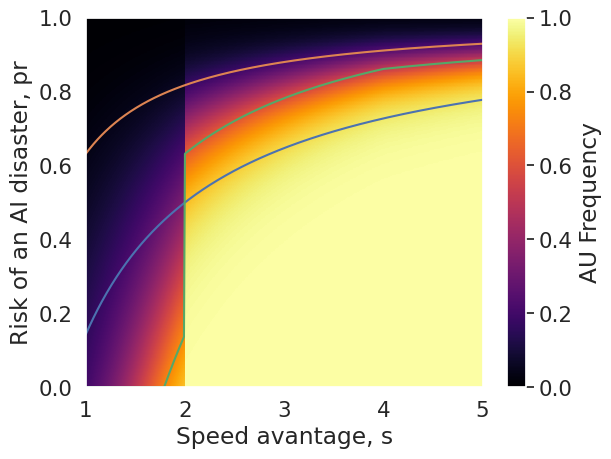

In [ ]:
#| exec_doc
#| echo:false
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    models = build_DSAIR(b=4,
                         c=1,
                         p=np.arange(0, 1 + 0.01, 0.01),
                         s=np.arange(1, 5 + 0.01, 0.01),
                         B=10**4,
                         W=10**3,
                         pfo=0,
                         α=0,
                         γ=0,
                         β=0.01,
                         Z=100,
                         strategy_set=["AS", "AU", "PS"],
                         collective_risk=0)
    # This time, we set α and γ as functions of s
    models['α'] = 1/4 * models['s']
    models['γ'] = 3/4 * models['s']
    results = thread_macro(models,
                           payoffs_sr_pfo_extension,
                           payoffs_lr_peer_punishment,
                           threshold_society_prefers_safety_dsair,
                           threshold_risk_dominant_safety_dsair,
                           threshold_ps_r_d_au,
                           markov_chain,
                          )

    df = thread_macro(results,
                      results_to_dataframe_egt,
                      process_dsair_data)
    table = df.pivot_table(index='pr', columns='s', values='AU_frequency')
    plot_heatmap(table,
             xlabel='Speed avantage, s',
             ylabel='Risk of an AI disaster, pr',
             zlabel='AU Frequency',
             cmap='inferno',
            )
    
    # Add threshold boundaries to convey dilemma region
    plt.plot(table.columns, df[df.pr==1]['threshold_society_prefers_safety'])
    plt.plot(table.columns, df[df.pr==1]['threshold_risk_dominant_safety'])
    plt.plot(table.columns, df[df.pr==0.5]['threshold_ps_risk_dominates_au']);

The analysis above is fairly comprehensive for our punishments model. A consideration of short term costs and benefits is unlikely to yield any further insights.

A further examination of punishments might consider more complex industry interactions. It seems unlikely that there will only be two firms in the race. Could punishments be more effective if there are multiple firms, and one firm can punish an unsafe one to encourage a remaining safe firm to win? This seems like it has the potential to be a useful extension.

## Rewards

/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:39: RuntimeWarning: invalid value encountered in divide
  (-b + (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:42: RuntimeWarning: divide by zero encountered in divide
  (-b - (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:68: RuntimeWarning: invalid value encountered in divide
  (-b + (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:71: RuntimeWarning: divide by zero encountered in divide
  (-b - (b**2 - 4*a*c)**0.5)/(2*a))


ValueError: too many values to unpack (expected 2)

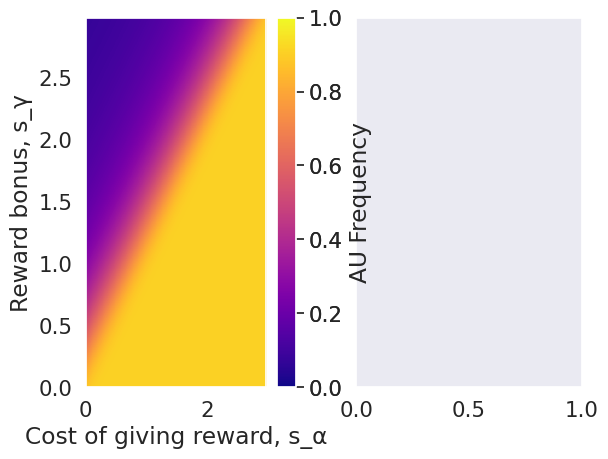

In [ ]:
#| exec_doc
#| echo:false
models = build_DSAIR(b=4,
                     c=1,
                     p=0.25,
                     s=1.5,
                     B=10**4,
                     W=10**2,
                     pfo=0,
                     α=np.arange(0, 3, 0.02),
                     γ=np.arange(0, 3, 0.02),
                     β=0.01,
                     Z=100,
                     strategy_set=["AS", "AU", "RS"],
                     collective_risk=0)

results = thread_macro(models,
                       payoffs_sr_pfo_extension,
                       payoffs_lr_peer_reward,
                       threshold_society_prefers_safety_dsair,
                       threshold_risk_dominant_safety_dsair,
                       markov_chain,
                      )

df = thread_macro(results,
                  results_to_dataframe_egt,
                  process_dsair_data)
table = df.pivot_table(index='γ', columns='α', values='AU_frequency')
fig, axs = plt.subplots(1, 2)
heatmap, _, _ = plot_heatmap(table,
                            figure_object=(fig, axs[0]),
                            xlabel='Cost of giving reward, s_α',
                            ylabel='Reward bonus, s_γ',
                            zlabel='AU Frequency',
                            cmap='plasma',
                           )
heatmap, _, _ = plot_heatmap(table,
                            figure_object=(fig, axs[1]),
                            xlabel='Cost of giving reward, s_α',
                            ylabel='Reward bonus, s_γ',
                            zlabel='AU Frequency',
                            cmap='plasma',
                           )
heatmap.show()

## Voluntary Commitments

We replicate a figure from the Voluntary Commitment paper below.

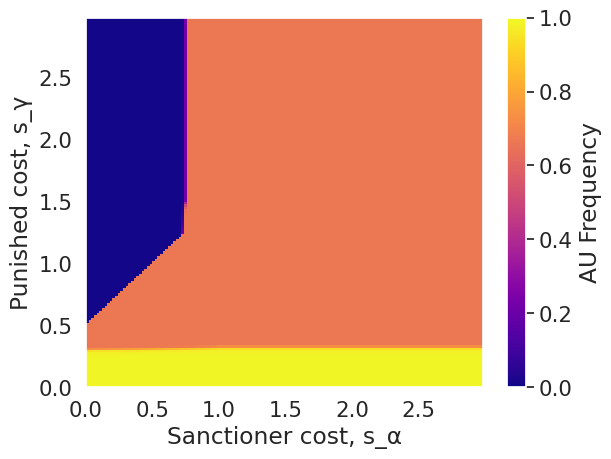

In [ ]:
#| exec_doc
#| echo:false
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    models = build_DSAIR(b=4,
                         c=1,
                         p=0.4,
                         s=1.5,
                         B=10**4,
                         W=10**2,
                         pfo=0,
                         epsilon=0,
                         α=np.arange(0, 3, 0.02),
                         γ=np.arange(0, 3, 0.02),
                         β=1,
                         Z=100,
                         strategy_set=["AS-out",
                                       "AU-out",
                                       "AS-in",
                                       "AU-in",
                                       "PV"],
                         collective_risk=0)

    results = thread_macro(models,
                           payoffs_sr_pfo_extension,
                           payoffs_lr_voluntary,
                           threshold_society_prefers_safety_dsair,
                           threshold_risk_dominant_safety_dsair,
                           markov_chain,
                          )

    df = thread_macro(results,
                      results_to_dataframe_egt,
                      process_dsair_data)
    df['AU_frequency'] = df['AU-in_frequency'] + df['AU-out_frequency']
    table = df.pivot_table(index='γ', columns='α', values='AU_frequency')
    plot_heatmap(table,
                 xlabel='Sanctioner cost, s_α',
                 ylabel='Punished cost, s_γ',
                 zlabel='AU Frequency',
                 cmap='plasma',
                )
    # display(df)

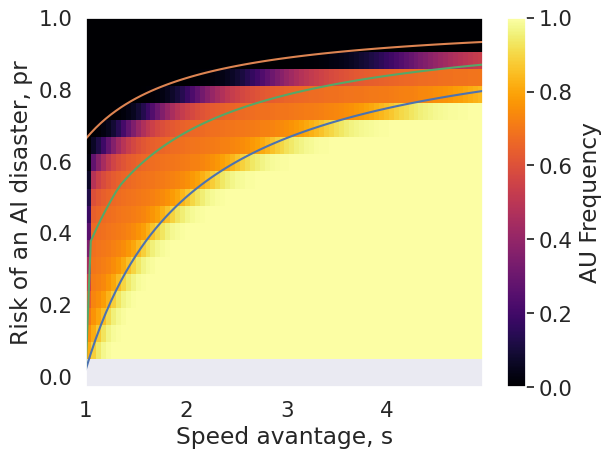

In [ ]:
#| exec_doc
#| echo:false
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    models = build_DSAIR(b=4,
                         c=1,
                         p=np.arange(0, 1, 0.05),
                         s=np.arange(1, 5, 0.05),
                         B=10**4,
                         W=10**2,
                         pfo=0,
                         α=0,
                         γ=0,
                         β=0.01,
                         Z=100,
                         strategy_set=["AS-out",
                                       "AU-out",
                                       "AS-in",
                                       "AU-in",
                                       "PV"],
                         collective_risk=0)
    # This time, we set α and γ as functions of s
    models['α'] = 3/4 * models['s']
    models['γ'] = 3/4 * models['s']
    results = thread_macro(models,
                           payoffs_sr_pfo_extension,
                           payoffs_lr_voluntary,
                           threshold_society_prefers_safety_dsair,
                           threshold_risk_dominant_safety_dsair,
                           threshold_ps_r_d_au,
                           markov_chain,
                          )

    df = thread_macro(results,
                      results_to_dataframe_egt,
                      process_dsair_data)
    df['AU_frequency'] = df['AU-in_frequency'] + df['AU-out_frequency']
    table = df.pivot_table(index='pr', columns='s', values='AU_frequency')
    plot_heatmap(table,
             xlabel='Speed avantage, s',
             ylabel='Risk of an AI disaster, pr',
             zlabel='AU Frequency',
             cmap='inferno',
            )
    
    # Add threshold boundaries to convey dilemma region
    plt.plot(table.columns, df[df.pr==1]['threshold_society_prefers_safety'])
    plt.plot(table.columns, df[df.pr==1]['threshold_risk_dominant_safety'])
    plt.plot(table.columns, df[df.pr==0.5]['threshold_ps_risk_dominates_au']);

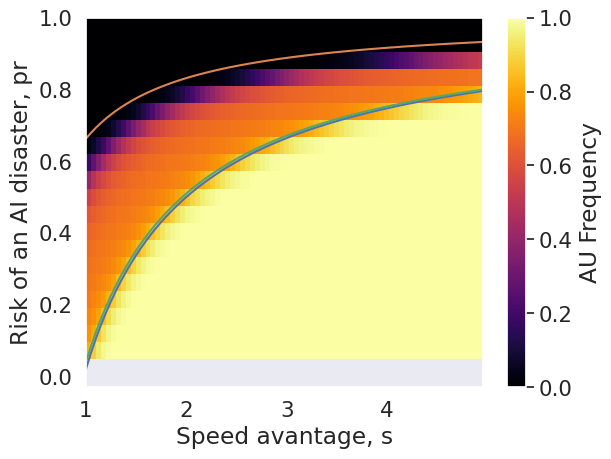

In [ ]:
#| exec_doc
#| echo:false
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    models = build_DSAIR(b=4,
                         c=1,
                         p=np.arange(0, 1, 0.05),
                         s=np.arange(1, 5, 0.05),
                         B=10**4,
                         W=10**2,
                         pfo=0,
                         α=0,
                         γ=0,
                         β=0.01,
                         Z=100,
                         strategy_set=["AS-out",
                                       "AU-out",
                                       "AS-in",
                                       "AU-in",
                                       "PV"],
                         collective_risk=0)
    # This time, we set α and γ as functions of s
    models['α'] = 4/4 * models['s']
    models['γ'] = 4/4 * models['s']
    results = thread_macro(models,
                           payoffs_sr_pfo_extension,
                           payoffs_lr_voluntary,
                           threshold_society_prefers_safety_dsair,
                           threshold_risk_dominant_safety_dsair,
                           threshold_ps_r_d_au,
                           markov_chain,
                          )

    df = thread_macro(results,
                      results_to_dataframe_egt,
                      process_dsair_data)
    df['AU_frequency'] = df['AU-in_frequency'] + df['AU-out_frequency']
    table = df.pivot_table(index='pr', columns='s', values='AU_frequency')
    plot_heatmap(table,
             xlabel='Speed avantage, s',
             ylabel='Risk of an AI disaster, pr',
             zlabel='AU Frequency',
             cmap='inferno',
            )
    
    # Add threshold boundaries to convey dilemma region
    plt.plot(table.columns, df[df.pr==1]['threshold_society_prefers_safety'])
    plt.plot(table.columns, df[df.pr==1]['threshold_risk_dominant_safety'])
    plt.plot(table.columns, df[df.pr==0.5]['threshold_ps_risk_dominates_au']);

#| hide

# References

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()